<a href="https://colab.research.google.com/github/ydeng-MLM/PINN_SIREN/blob/main/Guided_modes_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This Jupyter notebook implements a **finite-difference eigenmode solver** to compute the **guided modes in a rectangular dielectric waveguide**, with particular focus on solving Maxwell's equations in the frequency domain for integrated photonics applications.

The solver computes the **effective indices** $n_{\text{eff}}$ and the full **vectorial electromagnetic field distributions** (E and H) of the first few guided modes.

## Governing PDE

We solve the vectorial Helmholtz eigenvalue problem for a dielectric structure with spatially varying permittivity $\epsilon(x, y)$:

$$
\nabla^2 \mathbf{E} + k_0^2 \epsilon(x, y) \mathbf{E} = \beta^2 \mathbf{E}
$$

where:
- $ \mathbf{E} = (E_x, E_y, E_z) $ is the electric field vector,  
- $ \beta = k_0 n_{\text{eff}} $ is the propagation constant,  
- $ k_0 = \frac{2\pi}{\lambda} $ is the free-space wave number.

## Geometry

The waveguide has a **450 nm × 220 nm silicon core**, fully embedded in silica (SiO₂), a typical cross-section in silicon photonics.

## Mode Solver

We use a **fully vectorial finite-difference mode solver (EMpy)** to:
- Solve for the first few eigenmodes,
- Extract their effective indices,
- Visualize their field profiles,
- Study the dispersion behavior across the telecom band (1300–1600 nm).

## Goals

- Visualize the **TE₀** and **TM₀** mode profiles at standard wavelengths (1310 and 1550 nm).
- Compute and plot the **effective indices of the first 5 modes** across the telecom band.
- Briefly reflect on why **450 nm width** has become the industry standard in silicon photonics.


# Import & Environment Setup

## Default

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install SciencePlots

In [3]:
import scienceplots
plt.style.use(['science', 'notebook'])

## EMpy

In [4]:
!pip install git+https://github.com/lbolla/EMpy.git

  Cloning https://github.com/lbolla/EMpy.git to /tmp/pip-req-build-799xa4pk
  Running command git clone --filter=blob:none --quiet https://github.com/lbolla/EMpy.git /tmp/pip-req-build-799xa4pk
  Resolved https://github.com/lbolla/EMpy.git to commit 426f2ac3966e964edcd15d9c30c01a610e230185
  Preparing metadata (setup.py) ... done
  Created wheel for ElectroMagneticPython: filename=ElectroMagneticPython-2.2.1-py3-none-any.whl size=70350 sha256=adb9a0758f50900ad70fe8be1786bdcfbce33eaf48b680e1c503dd3857019347
  Stored in directory: /tmp/pip-ephem-wheel-cache-yi9zzhvq/wheels/b1/8e/8e/68475605423924353bc1316ad1033516fa98f2c6d6c0bd6049
Successfully built ElectroMagneticPython


In [5]:
import EMpy

# Helper Functions

In [6]:
def plot_full_vectorial_fields(solver, mode_idx, wl, x, y):
  # Extract fields
  Ex = solver.modes[mode_idx].get_field('Ex', x, y).T
  Ey = solver.modes[mode_idx].get_field('Ey', x, y).T
  Ez = solver.modes[mode_idx].get_field('Ez', x, y).T
  Hx = solver.modes[mode_idx].get_field('Hx', x, y).T
  Hy = solver.modes[mode_idx].get_field('Hy', x, y).T
  Hz = solver.modes[mode_idx].get_field('Hz', x, y).T

  fig, axes = plt.subplots(2, 3, figsize=(15, 8))

  im0 = axes[0,0].contourf(x * 1e6, y * 1e6, np.abs(Ex), levels=50, cmap='inferno')
  axes[0,0].set_title('|Ex|')
  axes[0,0].set_xlabel('x (µm)')
  axes[0,0].set_ylabel('y (µm)')
  fig.colorbar(im0, ax=axes[0,0])

  im1 = axes[0,1].contourf(x * 1e6, y * 1e6, np.abs(Ey), levels=50, cmap='inferno')
  axes[0,1].set_title('|Ey|')
  axes[0,1].set_xlabel('x (µm)')
  axes[0,1].set_ylabel('y (µm)')
  fig.colorbar(im1, ax=axes[0,1])

  im2 = axes[0,2].contourf(x * 1e6, y * 1e6, np.abs(Ez), levels=50, cmap='inferno')
  axes[0,2].set_title('|Ez|')
  axes[0,2].set_xlabel('x (µm)')
  axes[0,2].set_ylabel('y (µm)')
  fig.colorbar(im2, ax=axes[0,2])

  # Magnetic field plots
  im3 = axes[1,0].contourf(x * 1e6, y * 1e6, np.abs(Hx), levels=50, cmap='inferno')
  axes[1,0].set_title('|Hx|')
  axes[1,0].set_xlabel('x (µm)')
  axes[1,0].set_ylabel('y (µm)')
  fig.colorbar(im3, ax=axes[1,0])

  im4 = axes[1,1].contourf(x * 1e6, y * 1e6, np.abs(Hy), levels=50, cmap='inferno')
  axes[1,1].set_title('|Hy|')
  axes[1,1].set_xlabel('x (µm)')
  axes[1,1].set_ylabel('y (µm)')
  fig.colorbar(im4, ax=axes[1,1])

  im5 = axes[1,2].contourf(x * 1e6, y * 1e6, np.abs(Hz), levels=50, cmap='inferno')
  axes[1,2].set_title('|Hz|')
  axes[1,2].set_xlabel('x (µm)')
  axes[1,2].set_ylabel('y (µm)')
  fig.colorbar(im5, ax=axes[1,2])

  fig.suptitle(f'Mode {mode_idx} Field Distributions (λ = {wl*1e9:.0f} nm)', fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

# Mode Solver

The mode solver used in this notebook is from EMpy, an open-source PyPI package to solve electromagnetic problems.
```
Bolla, L. (2017). EMpy [Computer software]. https://github.com/lbolla/EMpy/
```



In [7]:
"""Fully vectorial finite-difference mode solver example."""

# Setting up the simulation domain and optical constants
def epsfunc(x_, y_):
    """Return a matrix describing a 2d material.

    :param x_: x values
    :param y_: y values
    :return: 2d-matrix
    """
    xx, yy = np.meshgrid(x_, y_)
    return np.where(
        (np.abs(xx.T - 1.24e-6) <= 0.225e-6) * (np.abs(yy.T - 1.11e-6) <= 0.11e-6),
        3.4757**2,
        1.446**2,
    )

wl = 1.55e-6
x = np.linspace(0, 2.48e-6, 125)
y = np.linspace(0, 2.22e-6, 112)

neigs = 5
tol = 1e-8
boundary = "0000"

After setting up the simulation domain and defining the material refractive indices, we compute the guided modes at 1310 nm and 1550 nm. The vectorial electric and magnetic field profiles for the first five modes are visualized, capturing the spatial distributions of all field components.

In Mode 0, we observe strong confinement of the $E_x$ component, characteristic of the fundamental $TE_0$ mode. Mode 1 exhibits dominant $H_x$ confinement, consistent with the $TM_0$ mode. While higher-order modes still display structured field patterns, their energy is no longer well confined within the central silicon core, indicating that they are no longer guided. These mode profiles clearly suggest that the **450 nm × 220 nm silicon waveguide** supports primarily single- or dual-mode operation.


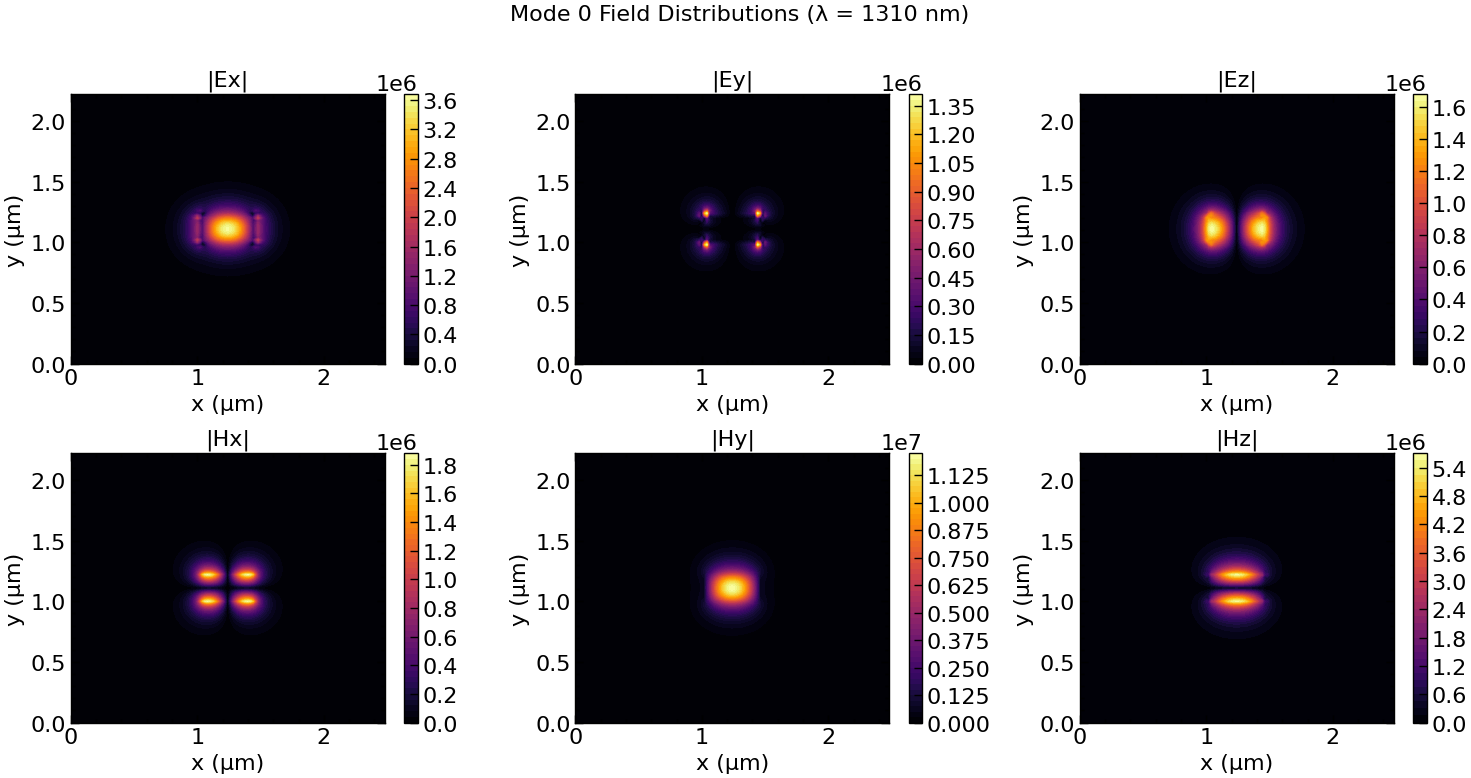

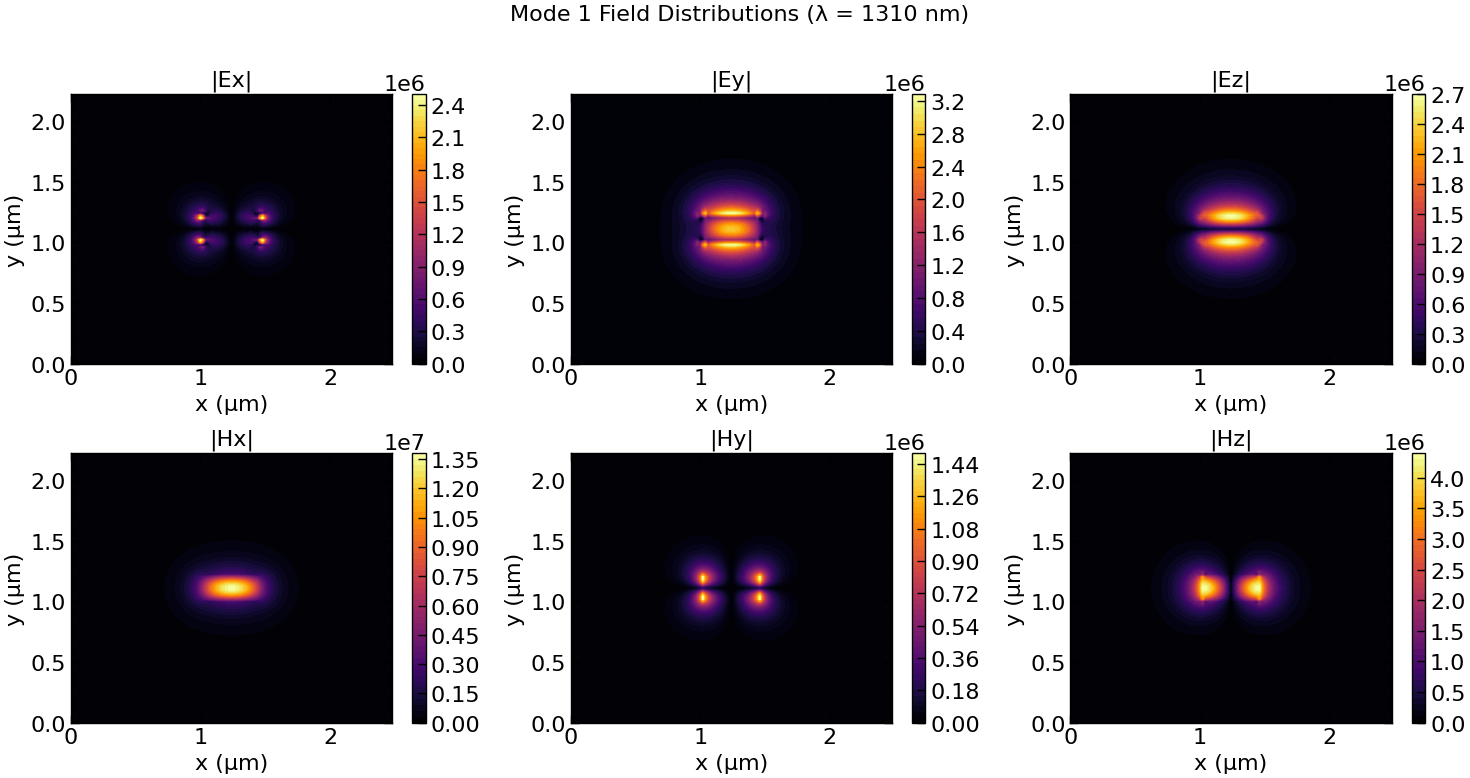

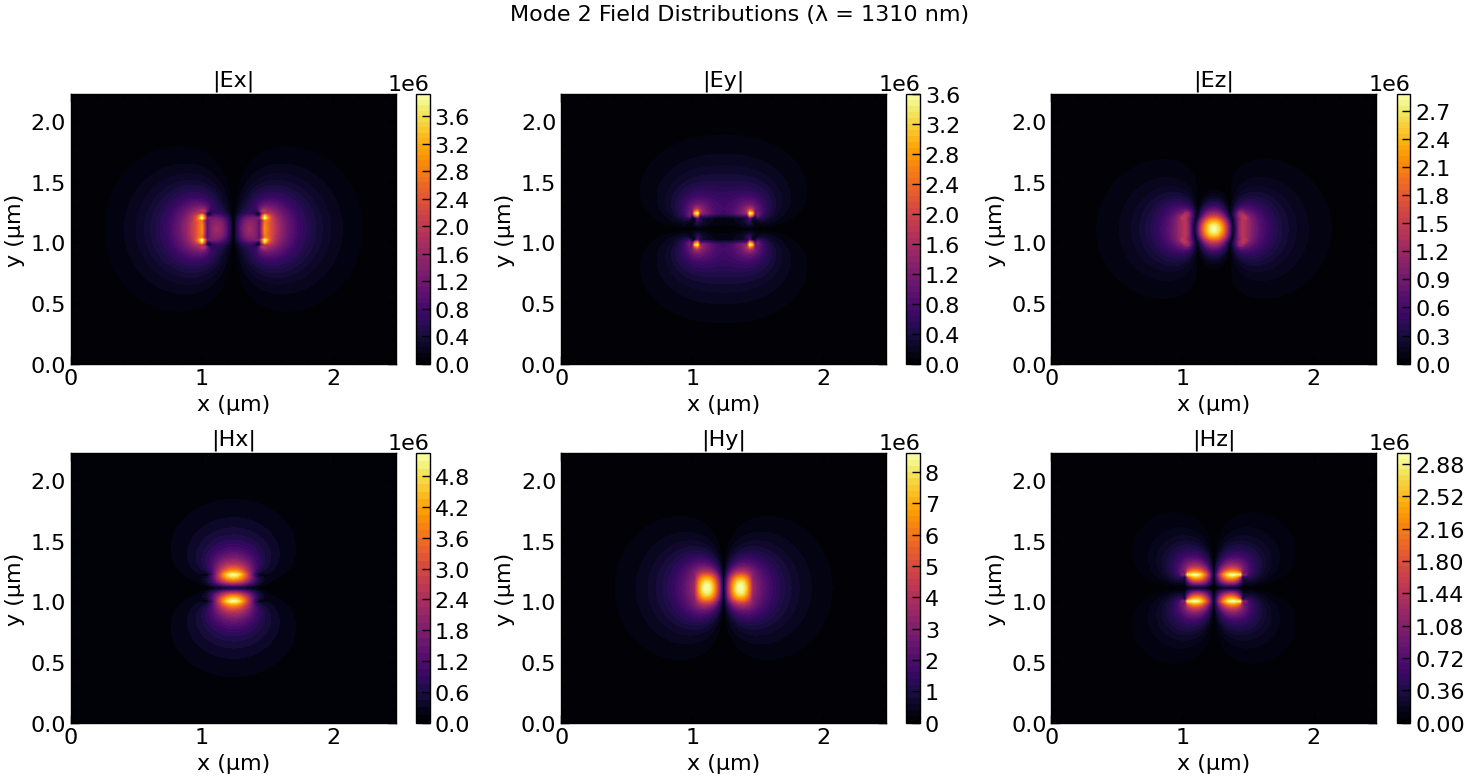

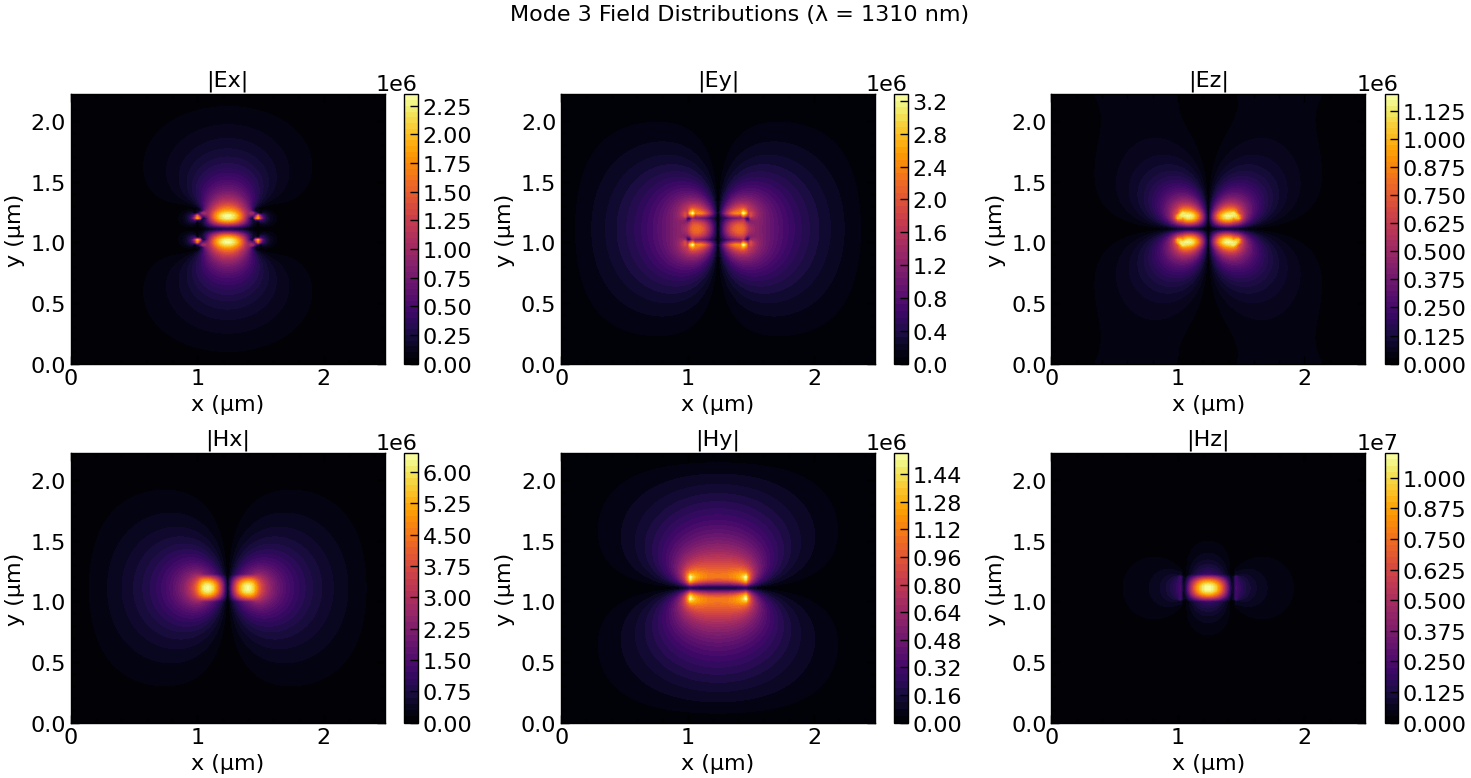

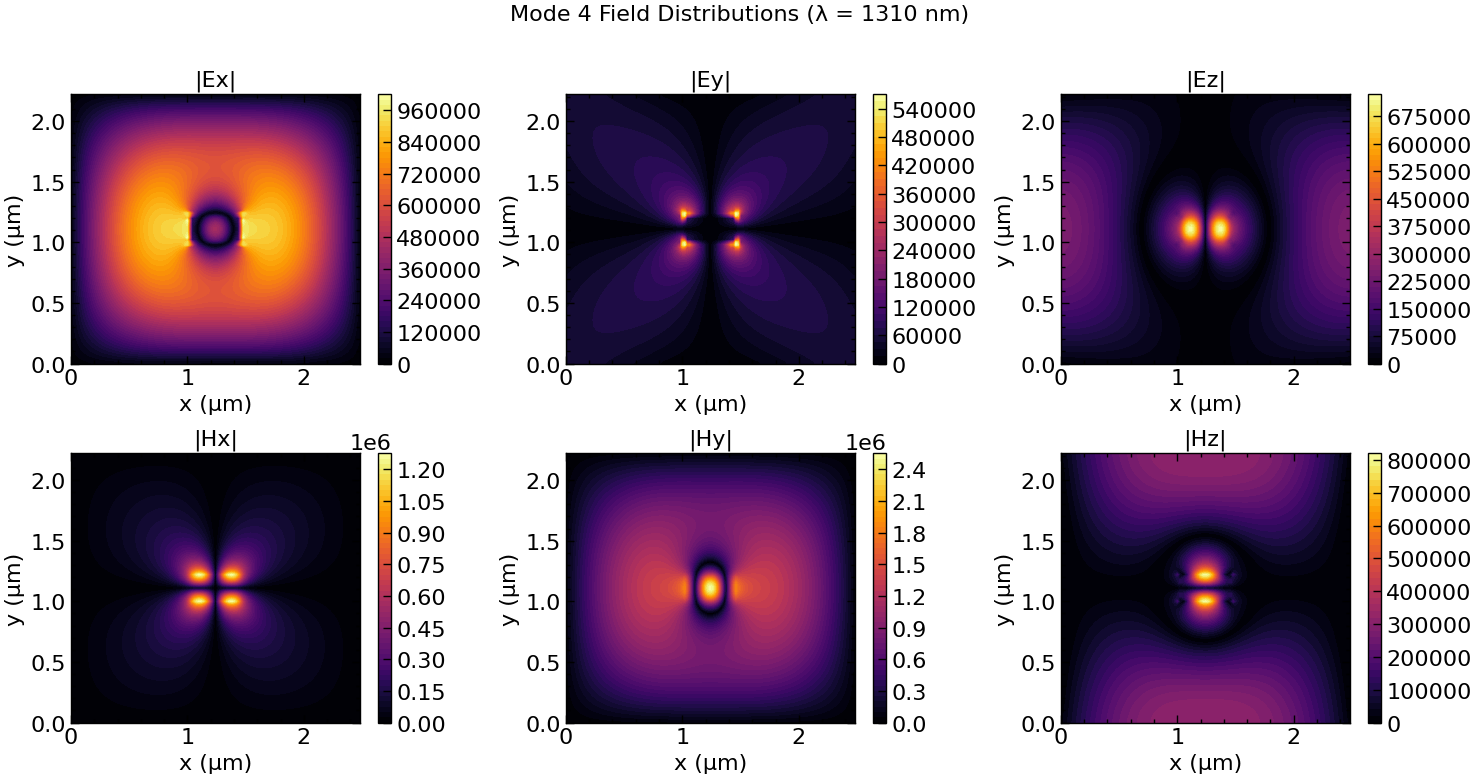

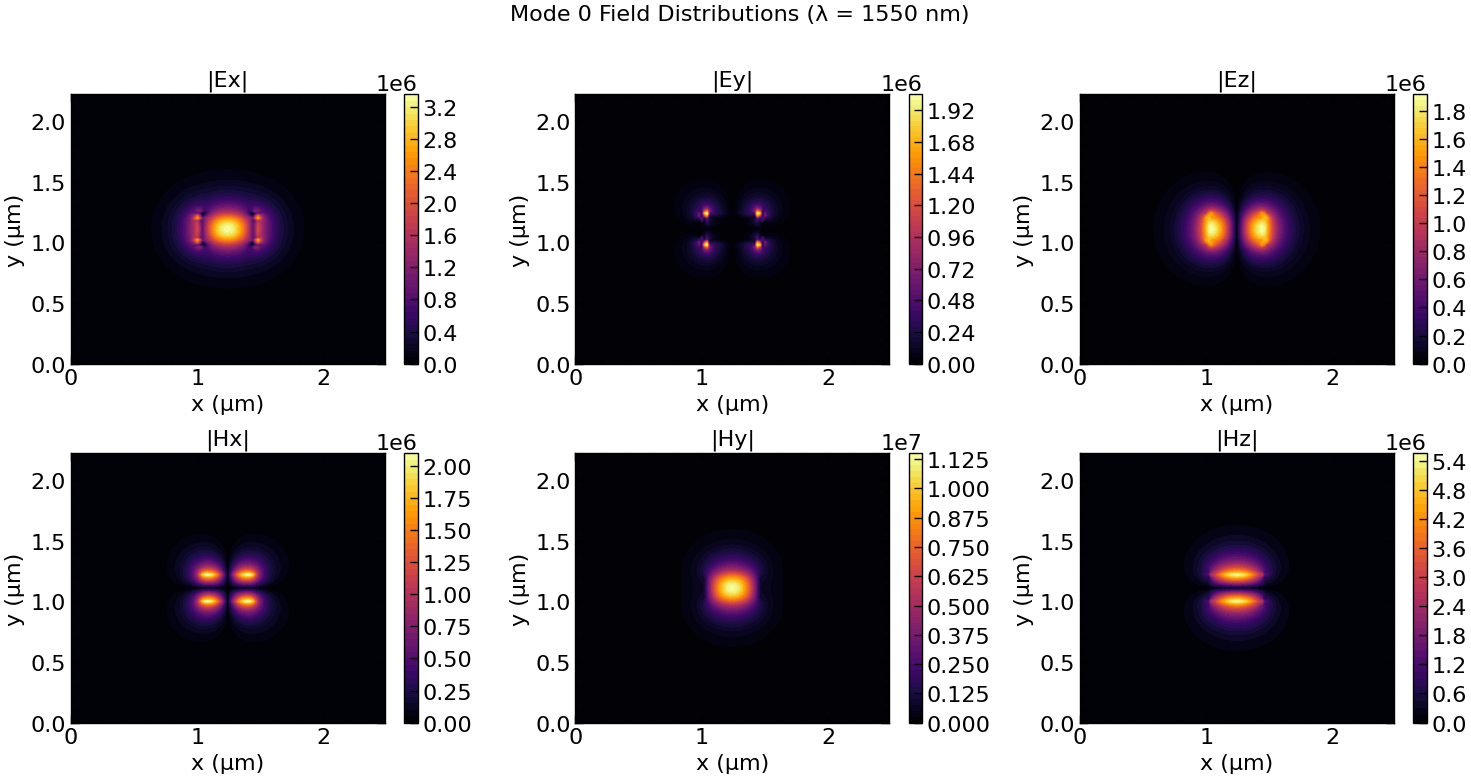

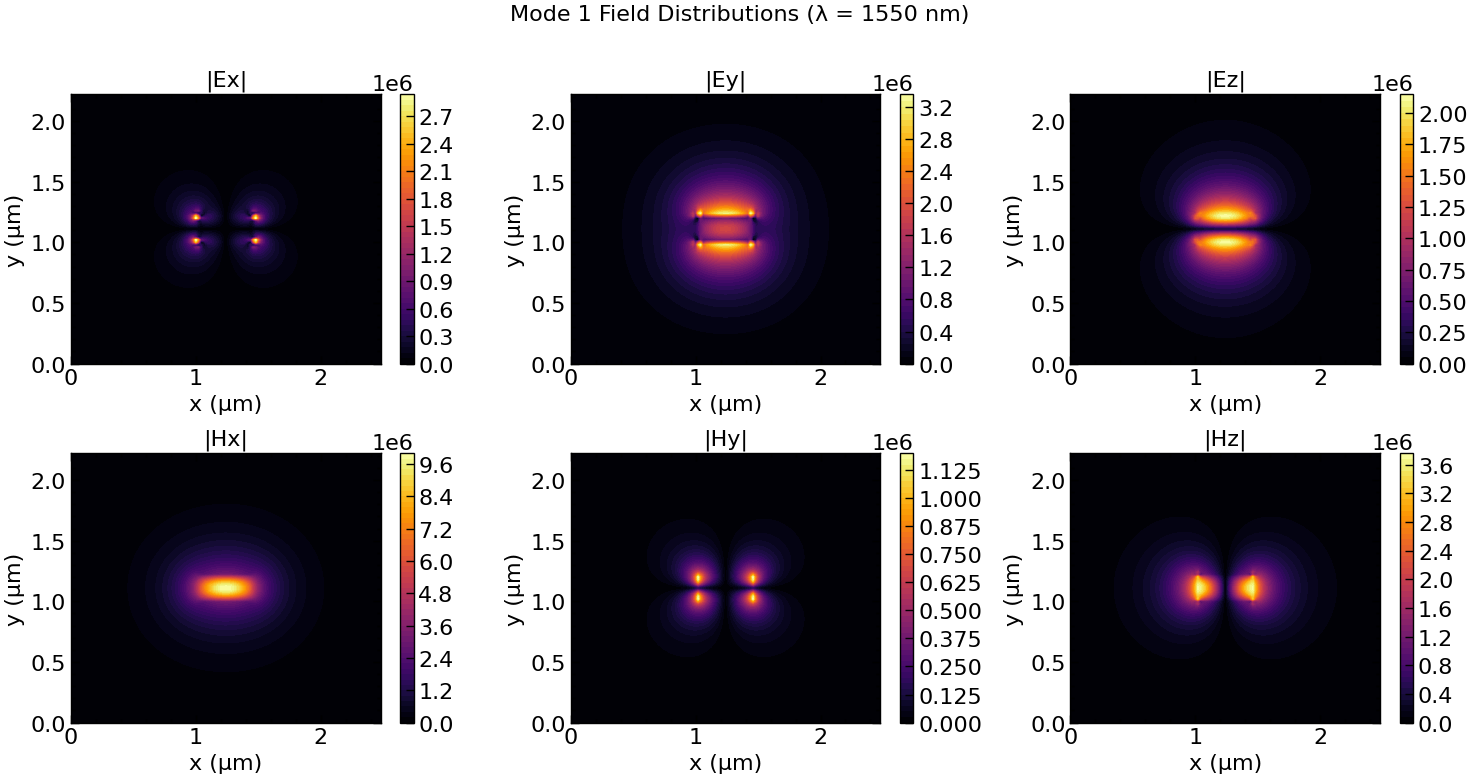

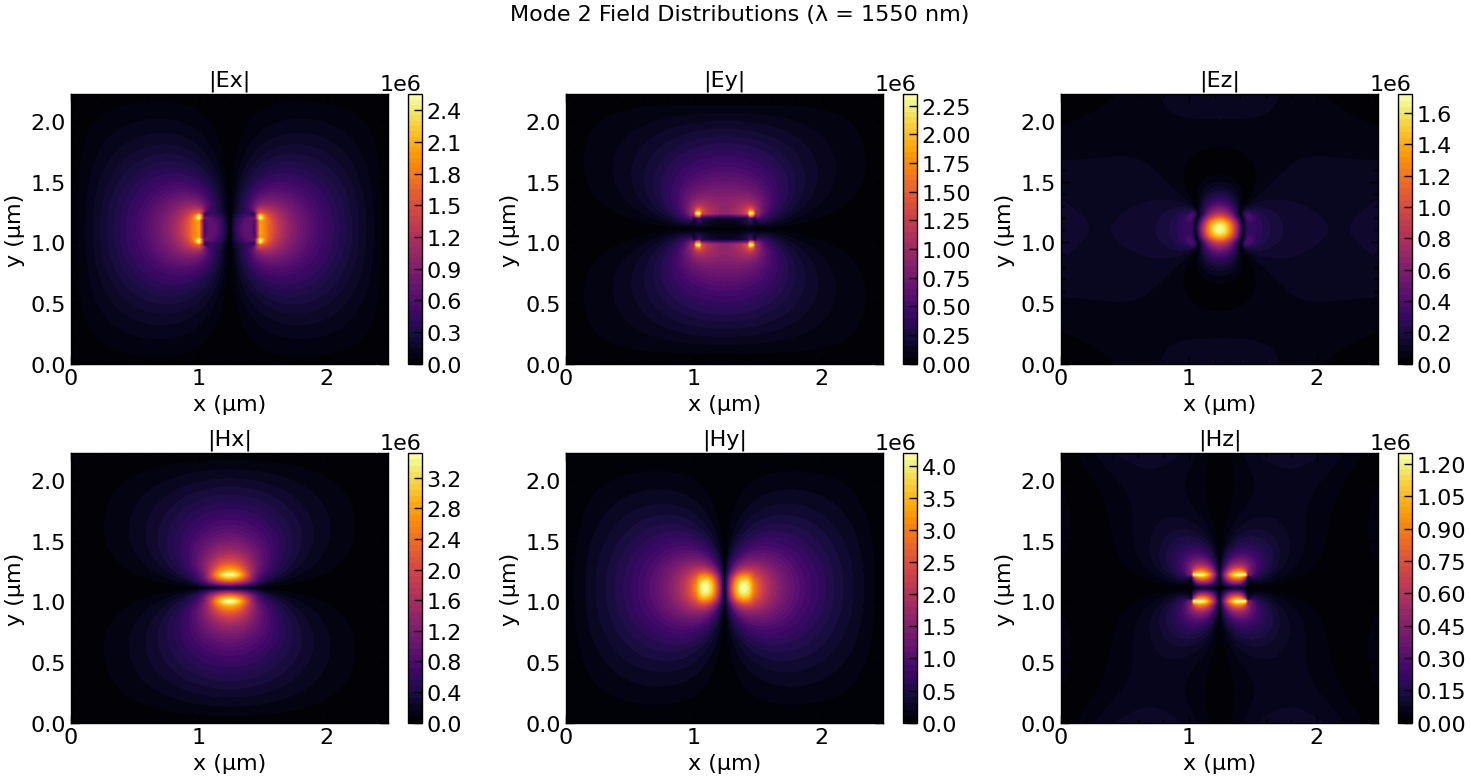

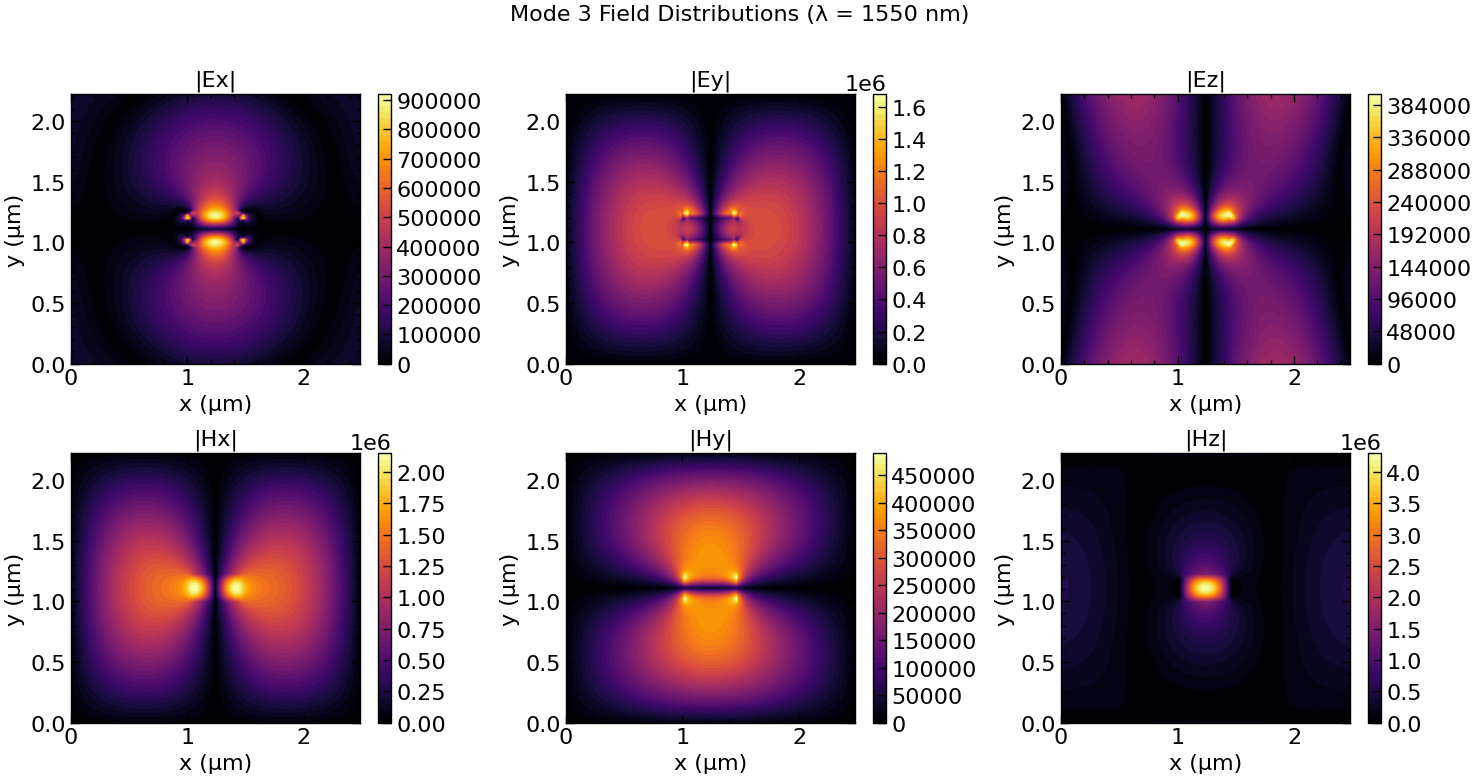

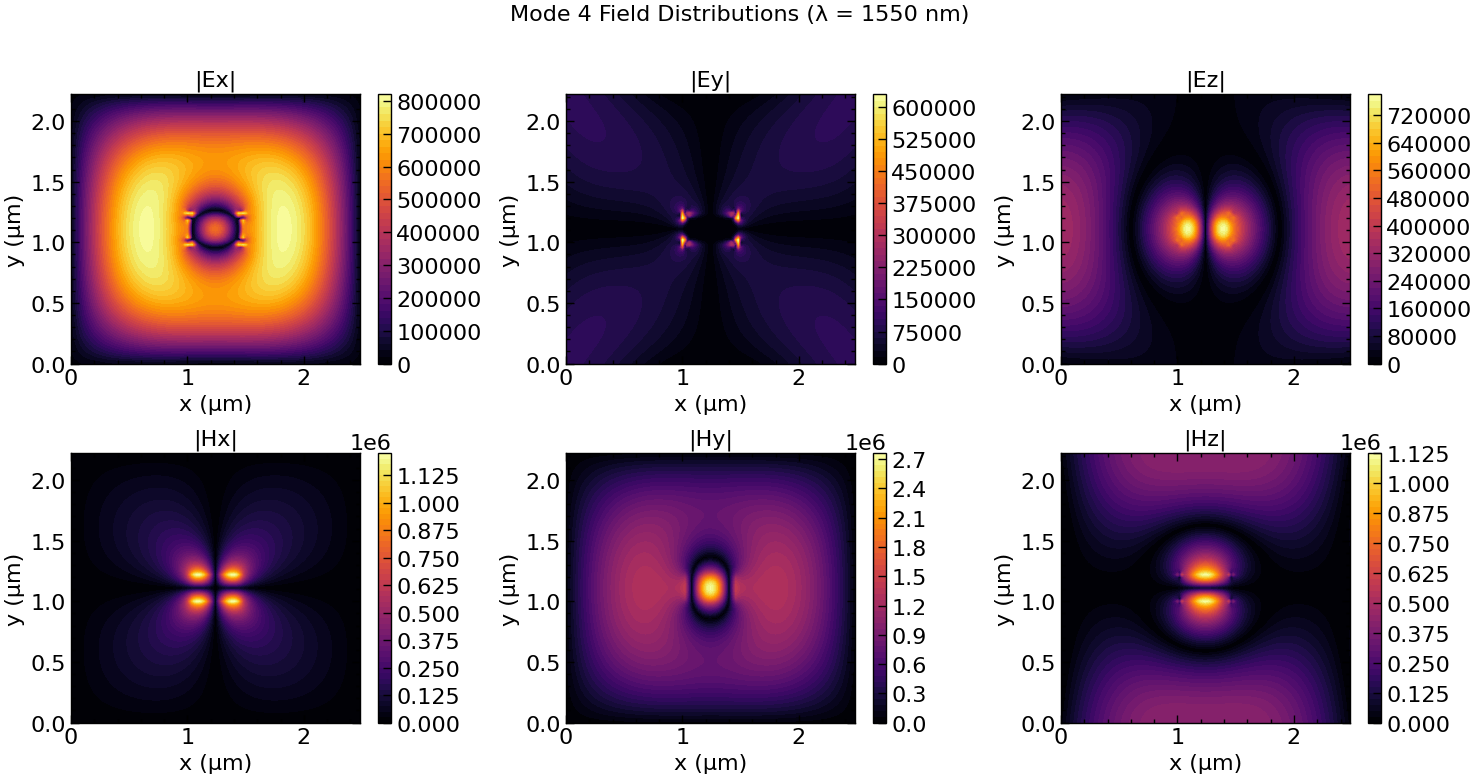

In [8]:
for wl in [1.31e-6, 1.55e-6]:
  solver = EMpy.modesolvers.FD.VFDModeSolver(wl, x, y, epsfunc, boundary).solve(
      neigs, tol
  )

  for mode_idx in range(neigs):
    plot_full_vectorial_fields(solver, mode_idx, wl, x, y)

We next compute the $n_{eff}$ of the first five modes from $1300nm$ to $1600nm$.

In [9]:
wls = np.linspace(1300e-9, 1600e-9, 301)
neff_all = [[] for _ in range(neigs)]

# Loop over wavelengths and solve for Mode 0 (TE0)
for wl in wls:
  solver = EMpy.modesolvers.FD.VFDModeSolver(wl, x, y, epsfunc, boundary).solve(
    neigs, tol
  )
  for mode_idx in range(neigs):
    neff = solver.modes[mode_idx].neff.real
    neff_all[mode_idx].append(neff)
    print(f"λ = {wl*1e9:.1f} nm, Mode {mode_idx}: n_eff = {neff:.6f}")

λ = 1300.0 nm, Mode 0: n_eff = 2.618220
λ = 1300.0 nm, Mode 1: n_eff = 2.121010
λ = 1300.0 nm, Mode 2: n_eff = 1.626744
λ = 1300.0 nm, Mode 3: n_eff = 1.492198
λ = 1300.0 nm, Mode 4: n_eff = 1.362752
λ = 1301.0 nm, Mode 0: n_eff = 2.617155
λ = 1301.0 nm, Mode 1: n_eff = 2.119256
λ = 1301.0 nm, Mode 2: n_eff = 1.625381
λ = 1301.0 nm, Mode 3: n_eff = 1.490671
λ = 1301.0 nm, Mode 4: n_eff = 1.362526
λ = 1302.0 nm, Mode 0: n_eff = 2.616089
λ = 1302.0 nm, Mode 1: n_eff = 2.117502
λ = 1302.0 nm, Mode 2: n_eff = 1.624025
λ = 1302.0 nm, Mode 3: n_eff = 1.489152
λ = 1302.0 nm, Mode 4: n_eff = 1.362300
λ = 1303.0 nm, Mode 0: n_eff = 2.615023
λ = 1303.0 nm, Mode 1: n_eff = 2.115750
λ = 1303.0 nm, Mode 2: n_eff = 1.622675
λ = 1303.0 nm, Mode 3: n_eff = 1.487641
λ = 1303.0 nm, Mode 4: n_eff = 1.362074
λ = 1304.0 nm, Mode 0: n_eff = 2.613957
λ = 1304.0 nm, Mode 1: n_eff = 2.113998
λ = 1304.0 nm, Mode 2: n_eff = 1.621333
λ = 1304.0 nm, Mode 3: n_eff = 1.486139
λ = 1304.0 nm, Mode 4: n_eff = 1.361848


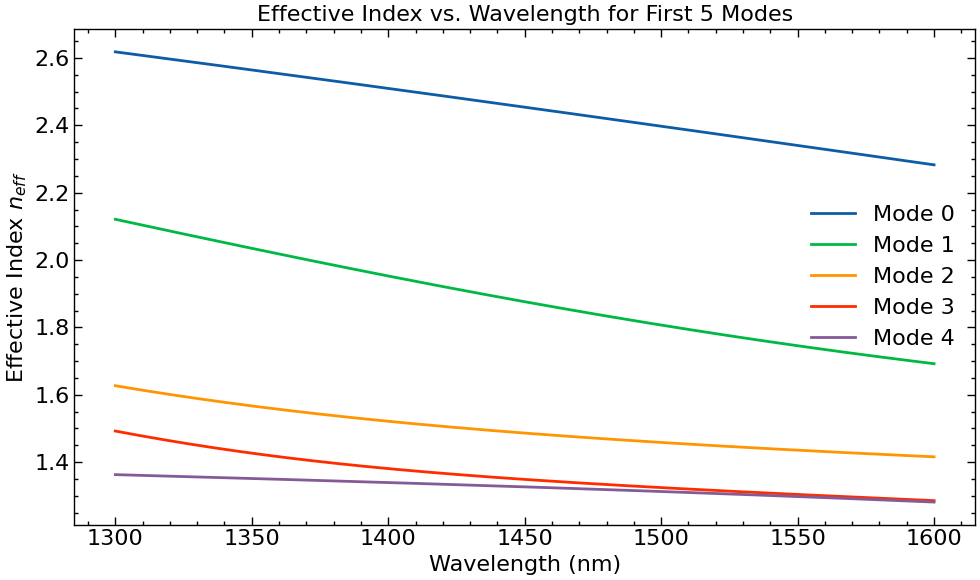

In [10]:
# Plot effective index vs wavelength
plt.figure(figsize=(10, 6))
for m in range(neigs):
    plt.plot(wls * 1e9, neff_all[m], label=f'Mode {m}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Effective Index $n_{eff}$')
plt.title('Effective Index vs. Wavelength for First 5 Modes')
plt.legend()
plt.tight_layout()
plt.show()

The 450 nm width provides strong confinement of the fundamental $\text{TE}_0$ mode, and also supports the $\text{TM}_0$ mode across the telecom spectrum (1300–1600 nm), while higher-order modes exhibit effective indices near the cladding and approach cutoff. This enables broadband single- or dual-mode operation with tight confinement, which is advantageous for low-crosstalk and compact photonic circuits. Additionally, the 450 nm waveguide width is compatible with standard CMOS fabrication processes and achieves high yield, helping establish it as the industry standard in silicon photonics.
